The goal of this notebook is to verify our implementation of the DMDc algorithm

In [1]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
 
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
from scipy.signal import cont2discrete
import pyvista as pv
import h5py
import mat73
import dask.array as da
from dask.distributed import Client, LocalCluster
import opinf
config = dotenv_values(".env")
from util import *
from scipy import signal

In [2]:
# # Setup Dask client
# # cluster = LocalCluster() # Launches a scheduler and workers locally
# # client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

In [3]:
# Hyperparameters for simulation
n = 5000 # dimension of full order state
l = 6 # dimension of input vector
m = 40 # dimension of output vector

n_timesteps = 500 # number of timesteps to simulate
dt = 0.01 # timestep size




In [4]:
# Make random linear system matrices with some sparsity where entries are drawn from normal distribution
A = np.random.rand(n,n)
A[np.abs(A<0.4)] = 0
A = A - np.diag(np.sum(A, axis=0))
B = np.random.rand(n, l)
C = np.random.rand(m, n)
D = np.zeros((m, l))



In [5]:
# Make discrete time linear system
dMats = signal.cont2discrete((A, B, C, D), dt=dt)
sys = signal.dlti(dMats[0], dMats[1], dMats[2], dMats[3], dt=dt)
A_d = dMats[0]
B_d = dMats[1]
C_d = dMats[2]
D_d = dMats[3]

In [6]:
# Set initial condition and input
x0 = np.zeros((n, 1))
u = (np.random.rand(l, n_timesteps)-0.5)*0.0001

# Set amount of gaussian noise to add to input
eps_input = 0.0000005
eps_output = 0.00001


In [7]:
# Simulate discrete time linear system
# Initialize array to hold state data and output data
X_fom = np.zeros((n, n_timesteps))
X_fom[:, [0]] = x0
Y_fom = np.zeros((m, n_timesteps))
Y_fom[:, [0]] = np.dot(C, x0)

In [8]:
# Simulate system
for i in range(1, n_timesteps):
    X_fom[:, i] = np.dot(A_d, X_fom[:, i-1]) + np.dot(B_d, u[:,i-1])# + np.random.normal(0, eps_input, (n, 1))[:,0]
    Y_fom[:, i] = np.dot(C_d, X_fom[:, i]) + np.dot(D_d, u[:,i-1])# + np.random.normal(0, eps_output, (m, 1))[:,0]

In [9]:
# Make DMDc Data matrices
X_train = da.from_array(X_fom[:, :-1], chunks=(n, 100))
Xprime_train = da.from_array(X_fom[:, 1:], chunks=(n, 100))
Upsilon_train = da.from_array(u[:, :-1], chunks=(l, 100))
Y_train = da.from_array(Y_fom[:, :-1], chunks=(m, 100))

In [10]:
# Rechunk data matrices to catch all columns in each chunk 
X_train = X_train.rechunk((4000, n_timesteps-1))
Xprime_train = Xprime_train.rechunk((4000, n_timesteps-1))
Upsilon_train = Upsilon_train.rechunk((l, n_timesteps-1))
Y_train = Y_train.rechunk((m, n_timesteps-1))



In [11]:
# Compute DMDc ROM
p_dmd = int(n/5)# dimension of reduced input space
n_ROM = 5 # dimension of reduced order state
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
print("got here 4")
# Decompose snapshot matrix using truncated SVD
r_dmd = n_ROM
print("got here 5")
U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
# Truncate SVD matrices to form rank p_dmd approximation
U_tilde = U_tilde[:,0:p_dmd]
Sigma_tilde = Sigma_tilde[0:p_dmd]
Vh_tilde = Vh_tilde[0:p_dmd,:]
# Vh_tilde = da.conj(da.transpose(V_tilde))
Sigma_tilde = da.diag(Sigma_tilde) # convert Sigma_tilde to diagonal matrix
U_hat, Sigma_hat, Vh_hat = da.linalg.svd(Xprime_train)
# Truncate SVD matrices to form rank r_dmd approximation
U_hat = U_hat[:,0:r_dmd]
Sigma_hat = Sigma_hat[0:r_dmd]
Vh_hat = Vh_hat[0:p_dmd,:]
Sigma_hat = da.diag(Sigma_hat) # convert Sigma_hat to diagonal matrix
print("got here 6")
# Compute system state evolution matrices
U_tilde_1 = U_tilde[0:n,:]
U_tilde_2 = U_tilde[n:,:]
A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

print("got here 7")

# Solve for system output matrix from full order system
ys = Y_train[:,0:250]

# compute approximate pseudoinverse of data matrix using SVD
# X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:250])
X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

print("got here 8")

# # X_PI = np.linalg.pinv(X_train[:,0:10])
C_dmdc = ys@X_PI
C_dmdc = C_dmdc@U_hat
print("got here 9")
# Execute computations for dmdc system matrices
print("Computing DMDc system matrices for n_ROM = ", n_ROM)
A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
# A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
# A_dmdc = A_dmdc.compute()
print("got here 10")
# B_dmdc = B_dmdc.compute()
# print("got here 11")
# C_dmdc = C_dmdc.compute()
# print("got here 12")
# U_hat = U_hat.compute()
# print("got here 13")
basis_dmdc = U_hat[:,0:n_ROM]



got here 4
got here 5
got here 6
got here 7
got here 8
got here 9
Computing DMDc system matrices for n_ROM =  5
got here 10


In [12]:
# Solve for C by projecting outputs onto reduced order state space


In [13]:
# Simulate DMDc ROM with same inputs
# Initialize array to hold state data and output data
X_dmdc = np.zeros((n_ROM, n_timesteps))
X_dmdc[:, [0]] = np.zeros((n_ROM, 1))
Y_dmdc = np.zeros((m, n_timesteps))
Y_dmdc[:, [0]] = np.zeros((m, 1))
# Simulate system
for i in range(1, n_timesteps):
    X_dmdc[:, i] = np.dot(A_dmdc, X_dmdc[:, i-1]) + np.dot(B_dmdc, u[:, i-1])
    Y_dmdc[:, i] = np.dot(C_dmdc, X_dmdc[:, i])

In [14]:
# Project reduced order state back to full order state
X_dmdc_full = np.dot(basis_dmdc, X_dmdc)

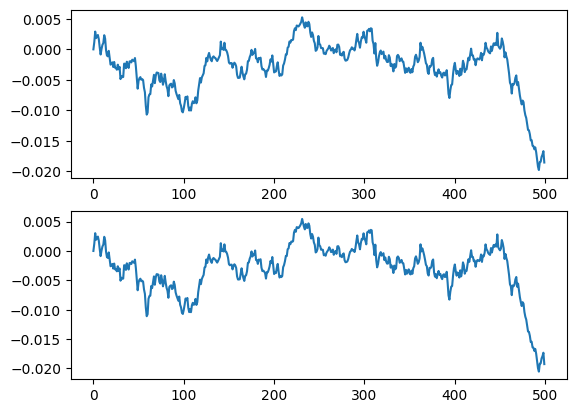

In [15]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 3
ax[0].plot(Y_fom[index, :1000])
ax[1].plot(Y_dmdc[index, :1000])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


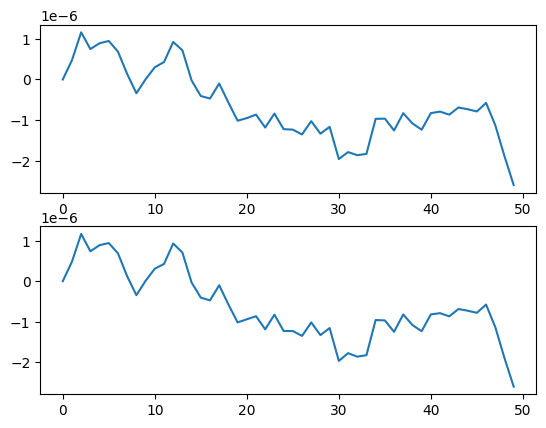

In [16]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 1
ax[0].plot(X_fom[index, :50])
ax[1].plot(X_dmdc_full[index, :50])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


In [17]:
# Compute relative errors between FOM and DMDc states and outputs
X_err = np.linalg.norm(X_fom - X_dmdc_full)/np.linalg.norm(X_fom)
Y_err = np.linalg.norm(Y_fom - Y_dmdc)/np.linalg.norm(Y_fom)
print("X error: ", X_err)
print("Y error: ", Y_err)

X error:  0.0025223560172851927
Y error:  0.05431172189718374


# Generate ROM on real dataset

In [18]:
####### # Set up hyperparameters ROMs  #######
n_timesteps = 2000 # Number of timesteps to pull from each episode
dt = 0.001
n_train = 1 # Number of training episodes
n_test = 2 # Number of testing episodes
ns_ROM = np.arange(12,14,2) # Dimensions of ROM state space



In [19]:
####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/"
romDir = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/ROMs/"

## No Shifting

In [20]:
# Read in all training data 
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
X_fom = X_fom[:,:,0:n_train]
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,:,0:n_train]
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))
Y_fom = Y_fom[:,:,0:n_train]
x0 = data["stateData"][:,0,0]
y0 = data["reducedCenterlineData"][:,0,0]
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,n_train))
Y0 = da.zeros((m,n_train))
for i in range(n_train):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    # X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    # Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done loading in data.")


Done loading in data.


In [21]:
####### Generate DMDc ROMs #######
print("Generating DMDc ROMs...")
print("got here 1")
# Initialize data matrices for training and testing
X_train = da.zeros((n,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
Xprime_train = da.zeros((n,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
Upsilon_train = da.zeros((l,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
Y_train = da.zeros((m,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
print("got here 2")
# Load in data from training episodes
for i in range(n_train):
    X_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,:-1,i]
    Xprime_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,1:,i]
    Upsilon_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = U_fom[:,:-1,i]
    Y_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = Y_fom[:,:-1,i]
print("got here 3")
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
print("got here 4")

for n_ROM in ns_ROM:
    # Decompose snapshot matrix using truncated SVD
    p_dmd = (n_timesteps-1)*n_train# dimension of reduced input space
    r_dmd = n_ROM
    print("got here 5")
    U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
    # Truncate SVD matrices to form rank p_dmd approximation
    U_tilde = U_tilde[:,0:p_dmd]
    Sigma_tilde = Sigma_tilde[0:p_dmd]
    Vh_tilde = Vh_tilde[0:p_dmd,:]
    # Vh_tilde = da.conj(da.transpose(V_tilde))
    Sigma_tilde = da.diag(Sigma_tilde) # convert Sigma_tilde to diagonal matrix
    U_hat, Sigma_hat, Vh_hat = da.linalg.svd(Xprime_train)
    # Truncate SVD matrices to form rank r_dmd approximation
    U_hat = U_hat[:,0:r_dmd]
    Sigma_hat = Sigma_hat[0:r_dmd]
    Vh_hat = Vh_hat[0:p_dmd,:]
    Sigma_hat = da.diag(Sigma_hat) # convert Sigma_hat to diagonal matrix
    print("got here 6")
    # Compute system state evolution matrices
    U_tilde_1 = U_tilde[0:n,:]
    U_tilde_2 = U_tilde[n:,:]
    A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
    B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

    print("got here 7")
    ys = Y_train[:,0:250]

    # compute approximate pseudoinverse of data matrix using SVD
    # X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
    U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:250])
    X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

    print("got here 8")

    # # X_PI = np.linalg.pinv(X_train[:,0:10])
    C_dmdc = ys@X_PI
    C_dmdc = C_dmdc@U_hat

    print("got here 9")
    # Execute computations for dmdc system matrices
    print("Computing DMDc system matrices for n_ROM = ", n_ROM)
    A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
    # A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
    # A_dmdc = A_dmdc.compute()
    print("got here 10")
    # B_dmdc = B_dmdc.compute()
    # print("got here 11")
    # C_dmdc = C_dmdc.compute()
    # print("got here 12")
    # U_hat = U_hat.compute()
    # print("got here 13")
    basis_dmdc = U_hat[:,0:n_ROM]
    # Save system matrices, projection mappings, and initial offset into file for later use
    # np.savez(romDir+f"dmdcSystemMatrices_{n_ROM}dim_{n_train}train.npz", A_dmdc=A_dmdc, B_dmdc=B_dmdc, C_dmdc=C_dmdc, x0=x0, y0=y0, basis_dmdc=basis_dmdc)
    # # save as .mat file
    # scipy.io.savemat(romDir+f"dmdcSystemMatrices_{n_ROM}dim_{n_train}train.mat", mdict={'A_dmdc': A_dmdc, 'B_dmdc': B_dmdc, 'C_dmdc': C_dmdc, 'x0': x0, 'y0': y0, 'basis_dmdc': basis_dmdc})

print("Done generating DMDc ROMs.")

Generating DMDc ROMs...
got here 1
got here 2
got here 3
got here 4
got here 5
got here 6
got here 7
got here 8
got here 9
Computing DMDc system matrices for n_ROM =  12
got here 10
Done generating DMDc ROMs.


In [22]:
x0.reshape(-1,1)

array([[-1.50000000e+02],
       [-7.63334063e+01],
       [-3.34515941e-05],
       ...,
       [-8.21364089e+02],
       [ 4.97173052e+01],
       [-1.40982079e+01]])

In [23]:
# Simulate DMDc ROM with same inputs
# Initialize array to hold state data and output data
X_dmdc = np.zeros((n_ROM, n_timesteps))
X_dmdc[:, [0]] = U_hat.conj().T@x0.reshape(-1,1)
Y_dmdc = np.zeros((m, n_timesteps))
Y_dmdc[:, [0]] = np.dot(C_dmdc, X_dmdc[:, [0]])
u = Upsilon_train.compute()
# Simulate system
for i in range(1, n_timesteps):
    X_dmdc[:, i] = np.dot(A_dmdc, X_dmdc[:, i-1]) + np.dot(B_dmdc, u[:, i-1])
    Y_dmdc[:, i] = np.dot(C_dmdc, X_dmdc[:, i])

In [24]:
# Project reduced order state back to full order state
X_dmdc_full = np.dot(basis_dmdc, X_dmdc)

In [25]:
Y0[:,0].compute()

array([-1.11331486e+03,  1.31459081e-06, -1.05742647e+03, -8.59299980e-02,
       -9.98461694e+02, -3.45863988e-02, -9.41038425e+02,  1.01201081e-02,
       -8.81734908e+02,  3.52514694e-01, -8.22617227e+02, -9.92111701e-02,
       -7.63000000e+02,  1.75101021e-01, -7.03964303e+02,  6.23173272e-02,
       -6.46527886e+02, -1.36672308e+00, -5.88202913e+02, -2.22713464e+00,
       -5.29898324e+02, -1.59102915e-01, -4.71036927e+02, -2.23424867e+00,
       -4.11038779e+02, -2.34423717e-01, -3.53730097e+02, -3.14268264e-01,
       -2.93850791e+02, -1.77082485e+00, -2.35472234e+02, -4.88199509e-02,
       -1.76140412e+02, -2.23985594e+00, -1.18237767e+02,  6.66401418e-02,
       -5.83994046e+01,  2.39443699e-01, -3.24921883e+00,  5.16541174e-01])

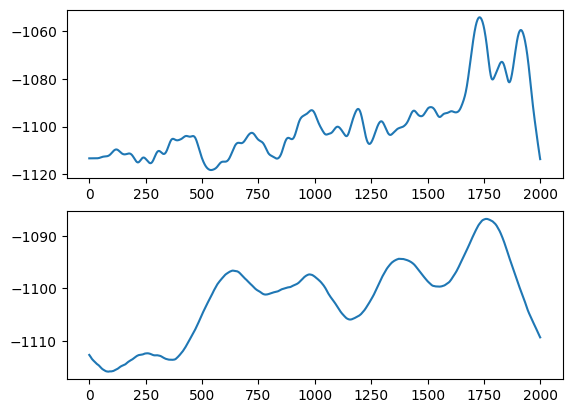

In [26]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 0
ax[0].plot(Y_fom[index, :2000])
ax[1].plot(Y_dmdc[index, :2000])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


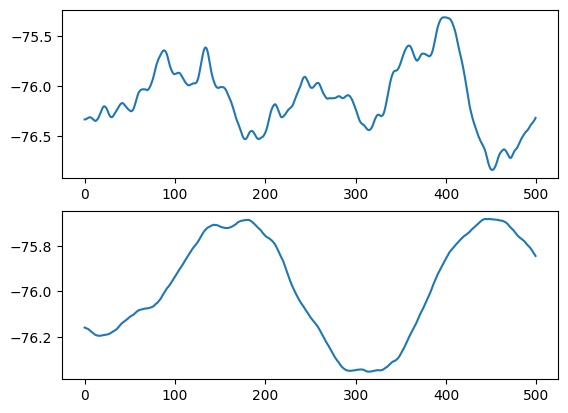

In [27]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 1
ax[0].plot(X_fom[index, :500])
ax[1].plot(X_dmdc_full[index, :500])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


In [28]:
X_fom[:,:,0].shape

(231336, 2000)

In [29]:
# Compute relative errors between FOM and DMDc states and outputs
X_err = np.linalg.norm(X_fom[:,:,0].compute() - X_dmdc_full)/np.linalg.norm(X_fom[:,:,0].compute())
Y_err = np.linalg.norm(Y_fom[:,:,0].compute() - Y_dmdc)/np.linalg.norm(Y_fom[:,:,0].compute())
print("X error: ", X_err)
print("Y error: ", Y_err)

X error:  0.009311452881826316
Y error:  0.04958357156474265


## With Shifting

In [30]:
####### Set up filepaths #######
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/"
romDir = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForRAL_goodMatParams/ROMs/"

In [31]:
# Read in all training data 
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
X_fom = X_fom[:,:,0:n_train]
U_fom = da.from_array(data["inputData"], chunks=(4096, 4096,1))
U_fom = U_fom[:,:,0:n_train]
Y_fom = da.from_array(data["reducedCenterlineData"], chunks=(4096, 4096,1))
Y_fom = Y_fom[:,:,0:n_train]
x0 = data["stateData"][:,0,0]
y0 = data["reducedCenterlineData"][:,0,0]
n = X_fom.shape[0]
l = U_fom.shape[0]
m = Y_fom.shape[0]
# # Collect initial condition offsets for each episode and center each episode
X0 = da.zeros((n,n_train))
Y0 = da.zeros((m,n_train))
for i in range(n_train):
    X0[:,i] = X_fom[:,0,i]
    Y0[:,i] = Y_fom[:,0,i]
    X_fom[:,:,i] = X_fom[:,:,i] - X0[:,i].reshape(-1,1)
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y0[:,i].reshape(-1,1)
print("Done loading in data.")


Done loading in data.


In [32]:
####### Generate DMDc ROMs #######
print("Generating DMDc ROMs...")
print("got here 1")
# Initialize data matrices for training and testing
X_train = da.zeros((n,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
Xprime_train = da.zeros((n,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
Upsilon_train = da.zeros((l,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
Y_train = da.zeros((m,(n_timesteps-1)*n_train), chunks=(4096, (n_timesteps-1)*n_train))
print("got here 2")
# Load in data from training episodes
for i in range(n_train):
    X_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,:-1,i]
    Xprime_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = X_fom[:,1:,i]
    Upsilon_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = U_fom[:,:-1,i]
    Y_train[:,i*(n_timesteps-1):(i+1)*(n_timesteps-1)] = Y_fom[:,:-1,i]
print("got here 3")
# Form snapshot matrices for DMDc
Omega = da.concatenate([X_train,Upsilon_train],axis=0)
print("got here 4")

for n_ROM in ns_ROM:
    # Decompose snapshot matrix using truncated SVD
    p_dmd = (n_timesteps-1)*n_train# dimension of reduced input space
    r_dmd = n_ROM
    print("got here 5")
    U_tilde,Sigma_tilde,Vh_tilde = da.linalg.svd(Omega)
    # Truncate SVD matrices to form rank p_dmd approximation
    U_tilde = U_tilde[:,0:p_dmd]
    Sigma_tilde = Sigma_tilde[0:p_dmd]
    Vh_tilde = Vh_tilde[0:p_dmd,:]
    # Vh_tilde = da.conj(da.transpose(V_tilde))
    Sigma_tilde = da.diag(Sigma_tilde) # convert Sigma_tilde to diagonal matrix
    U_hat, Sigma_hat, Vh_hat = da.linalg.svd(Xprime_train)
    # Truncate SVD matrices to form rank r_dmd approximation
    U_hat = U_hat[:,0:r_dmd]
    Sigma_hat = Sigma_hat[0:r_dmd]
    Vh_hat = Vh_hat[0:p_dmd,:]
    Sigma_hat = da.diag(Sigma_hat) # convert Sigma_hat to diagonal matrix
    print("got here 6")
    # Compute system state evolution matrices
    U_tilde_1 = U_tilde[0:n,:]
    U_tilde_2 = U_tilde[n:,:]
    A_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_1.conj().T)@U_hat
    B_dmdc = (U_hat.conj().T)@Xprime_train@(Vh_tilde.conj().T)@(da.linalg.inv(Sigma_tilde))@(U_tilde_2.conj().T)

    print("got here 7")
    ys = Y_train[:,0:250]

    # compute approximate pseudoinverse of data matrix using SVD
    # X_train = X_train.rechunk((2000,X_train.shape[1])) # Rechunk along one dimension
    U_X_train, S_X_train, Vh_X_train = da.linalg.svd(X_train[:,0:250])
    X_PI = da.matmul(da.transpose(Vh_X_train),da.matmul(da.diag(da.reciprocal(S_X_train)),da.transpose(U_X_train)))

    print("got here 8")

    # # X_PI = np.linalg.pinv(X_train[:,0:10])
    C_dmdc = ys@X_PI
    C_dmdc = C_dmdc@U_hat

    print("got here 9")
    # Execute computations for dmdc system matrices
    print("Computing DMDc system matrices for n_ROM = ", n_ROM)
    A_dmdc, B_dmdc, C_dmdc,U_hat = da.compute(A_dmdc, B_dmdc, C_dmdc,U_hat)
    # A_dmdc, B_dmdc = da.compute(A_dmdc, B_dmdc)
    # A_dmdc = A_dmdc.compute()
    print("got here 10")
    # B_dmdc = B_dmdc.compute()
    # print("got here 11")
    # C_dmdc = C_dmdc.compute()
    # print("got here 12")
    # U_hat = U_hat.compute()
    # print("got here 13")
    basis_dmdc = U_hat[:,0:n_ROM]
    # Save system matrices, projection mappings, and initial offset into file for later use
    # np.savez(romDir+f"dmdcSystemMatrices_{n_ROM}dim_{n_train}train.npz", A_dmdc=A_dmdc, B_dmdc=B_dmdc, C_dmdc=C_dmdc, x0=x0, y0=y0, basis_dmdc=basis_dmdc)
    # # save as .mat file
    # scipy.io.savemat(romDir+f"dmdcSystemMatrices_{n_ROM}dim_{n_train}train.mat", mdict={'A_dmdc': A_dmdc, 'B_dmdc': B_dmdc, 'C_dmdc': C_dmdc, 'x0': x0, 'y0': y0, 'basis_dmdc': basis_dmdc})

print("Done generating DMDc ROMs.")

Generating DMDc ROMs...
got here 1
got here 2
got here 3
got here 4
got here 5
got here 6
got here 7
got here 8
got here 9
Computing DMDc system matrices for n_ROM =  12
got here 10
Done generating DMDc ROMs.


In [33]:
# Simulate DMDc ROM with same inputs
# Initialize array to hold state data and output data
X_dmdc = np.zeros((n_ROM, n_timesteps))
X_dmdc[:, [0]] = np.zeros((n_ROM, 1))
Y_dmdc = np.zeros((m, n_timesteps))
Y_dmdc[:, [0]] = np.dot(C_dmdc, X_dmdc[:, [0]])
u = Upsilon_train.compute()
# Simulate system
for i in range(1, n_timesteps):
    X_dmdc[:, i] = np.dot(A_dmdc, X_dmdc[:, i-1]) + np.dot(B_dmdc, u[:, i-1])
    Y_dmdc[:, i] = np.dot(C_dmdc, X_dmdc[:, i])

In [34]:
# Project reduced order state back to full order state
X_dmdc_full = np.dot(basis_dmdc, X_dmdc)
# # Unshift full order state and outputs
# X_dmdc_full = X_dmdc_full #+ X0[:,0].reshape(-1,1)
# X_fom = X_fom[:,:,0] #+ X0[:,0].reshape(-1,1)
# Y_dmdc = Y_dmdc #+ Y0[:,0].reshape(-1,1)
# Y_fom = Y_fom[:,:,0] #+ Y0[:,0].reshape(-1,1)


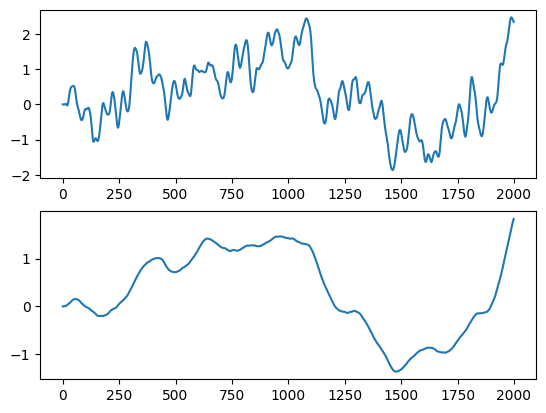

In [35]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 30
ax[0].plot(Y_fom[index, :2000])
ax[1].plot(Y_dmdc[index, :2000])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


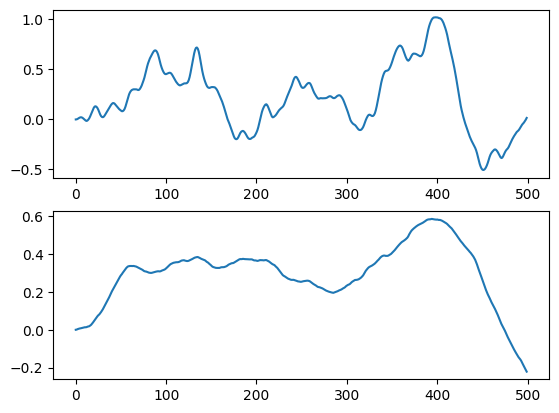

In [36]:
# Plot first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 1
ax[0].plot(X_fom[index, :500])
ax[1].plot(X_dmdc_full[index, :500])
plt.show()

# ax.plot(Y_fom[0, :1000], label="FOM")
# ax.plot(Y_dmdc[2, :1000], label="DMDc")
# ax.legend()
plt.show()


In [37]:
# Compute relative errors between FOM and DMDc states and outputs
X_err = np.linalg.norm(X_fom[:,:,0].compute() - X_dmdc_full)/np.linalg.norm(X_fom[:,:,0].compute())
Y_err = np.linalg.norm(Y_fom[:,:,0].compute() - Y_dmdc)/np.linalg.norm(Y_fom[:,:,0].compute())
print("X error: ", X_err)
print("Y error: ", Y_err)

X error:  0.28701093525598254
Y error:  0.9973620955058393


In [38]:
# Now unshift the data and compute the errors
X_dmdc_full_unshift = X_dmdc_full + X0[:,0].compute().reshape(-1,1)
X_fom_unshift = X_fom[:,:,0] + X0[:,0].reshape(-1,1)
X_fom_unshift = X_fom_unshift.compute()
Y_dmdc_unshift = Y_dmdc + Y0[:,0].compute().reshape(-1,1)
Y_fom_unshift = Y_fom[:,:,0] + Y0[:,0].reshape(-1,1)
Y_fom_unshift = Y_fom_unshift.compute()
# Compute relative errors between FOM and DMDc states and outputs
X_err = np.linalg.norm(X_fom_unshift - X_dmdc_full_unshift)/np.linalg.norm(X_fom_unshift)
Y_err = np.linalg.norm(Y_fom_unshift - Y_dmdc_unshift)/np.linalg.norm(Y_fom_unshift)
print("X error: ", X_err)
print("Y error: ", Y_err)

X error:  0.0076740864448437375
Y error:  0.04860544823932105


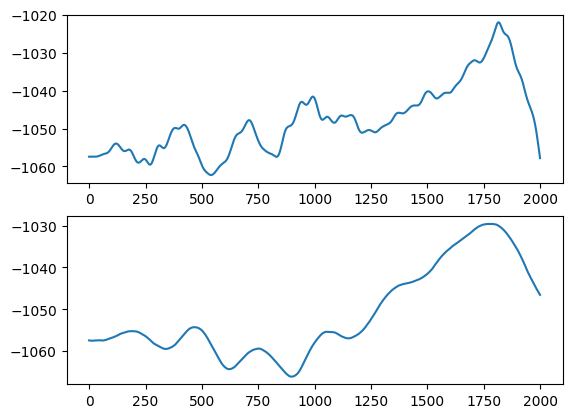

In [40]:
# Plot unshifted first dmdc output vs first fom output on separate plots
fig, ax = plt.subplots(2, 1)
index = 2
ax[0].plot(Y_fom_unshift[index, :2000])
ax[1].plot(Y_dmdc_unshift[index, :2000])
plt.show()
